In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Output file structure

Output is written to directory called *output* with following structure:

```
<output-dir>/
├── g00.txt
├── hamiltonian_sum.txt
├── log
├── momentum_sum.txt
├── steps
└── time.txt
```

*g00.txt*: spatial metric g_00.

*hamiltonian_sum.txt*: sum of Hamiltonian constraints

*log*: contains information about the run including:

- grid size
- time step
- number of time steps
- number of implicit euler substesp
- value used to clamp conformal factor $W$
- dump creation interval

*momentum_sum.txt*: sum of components of momentum constraints.

*steps*: contains runtime of each calculated time step and marks at which points dumps were created.

*time.txt*: time coordinates at each time step.

In [6]:
def read_output(output_dir_path):
    """
    Args:
        output_dir_path (str): The path to the output directory.

    Returns:
        ndarray: elapsed time t_i.
        ndarray: hamiltonian sum H_i
        ndarray: momentum sum M_i
        ndarray: metric (g00)_in, where n is the x coordinate.
    """

    time_arr = np.loadtxt(output_dir_path + "/time.txt")
    H_arr = np.loadtxt(output_dir_path + "/hamiltonian_sum.txt")
    M_arr = np.loadtxt(output_dir_path + "/momentum_sum.txt")
    g00_arr = np.loadtxt(output_dir_path + "/g00.txt")

    return time_arr, H_arr, M_arr, g00_arr

In [67]:
def minkowski_g00(t_arr, x_arr):
    assert len(t_arr.shape) == 1
    assert len(x_arr.shape) == 1
    
    return np.ones((len(t_arr), len(x_arr)))

def gauge_wave_g00(t_arr, x_arr):
    assert len(t_arr.shape) == 1
    assert len(x_arr.shape) == 1

    t_2arr = t_arr[:, np.newaxis]
    x_2arr = x_arr[np.newaxis, :]

    # Wavelength set to simulation width
    # assuming simulation x coordinates are 0, ..., N - 1
    N = len(x_arr)
    d = N
    A = 0.1
    
    H = A * np.sin(2 * np.pi * (t_2arr - x_2arr) / d)
    
    return 1 - H

In [87]:
def plot_output(output_dir_path, g00_theory):
    t_arr, H_arr, M_arr, g00_arr = read_output(output_dir_path)

    fig, ((H_ax, M_ax), (g00_ax, g00_theory_ax)) = plt.subplots(2, 2)

    # Assume grid points (i, j, k) are at coordinates (i, j, k)
    # and that j == k == 0.
    N = len(g00_arr[0, :])
    x_arr = np.arange(N)

    H_ax.plot(t_arr, H_arr, label="Hamiltonian sum")
    M_ax.plot(t_arr, M_arr, label="Momentum sum")

    #g00_img = g00_ax.matshow(g00_arr,
    #                         extent=(0, N - 1, 0, t_arr[-1]))
    g00_img = g00_ax.pcolormesh(x_arr, t_arr, g00_arr)
    g00_cbar = fig.colorbar(g00_img)

    g00_theory_arr = g00_theory(t_arr, x_arr)
    #g00_theory_img = g00_theory_ax.matshow(g00_theory_arr, 
    #                                       extent=(0, N - 1, t_arr[-1], 0))
    g00_theory_img = g00_theory_ax.pcolormesh(x_arr, t_arr, g00_theory_arr) 
    g00_theory_cbar = fig.colorbar(g00_theory_img)

    H_ax.set(xlabel="t",
             ylabel="Hamiltonian constraint sum")
    M_ax.set(xlabel="t",
             ylabel="Momentum constraint sum")
    g00_ax.set(xlabel="x",
               ylabel="t")
    g00_theory_ax.set(xlabel="x",
                      ylabel="t")

    
    #g00_cbar.ax.get_yaxis().labelpad = 15
    g00_cbar.ax.set_ylabel("$\\gamma_{00}$", rotation=90)
    
    #g00_theory_cbar.ax.get_yaxis().labelpad = 15
    g00_theory_cbar.ax.set_ylabel("$\\gamma_{00}$ theory", rotation=90)

    fig.suptitle(pathlib.Path(output_dir_path).stem)
    fig.tight_layout()

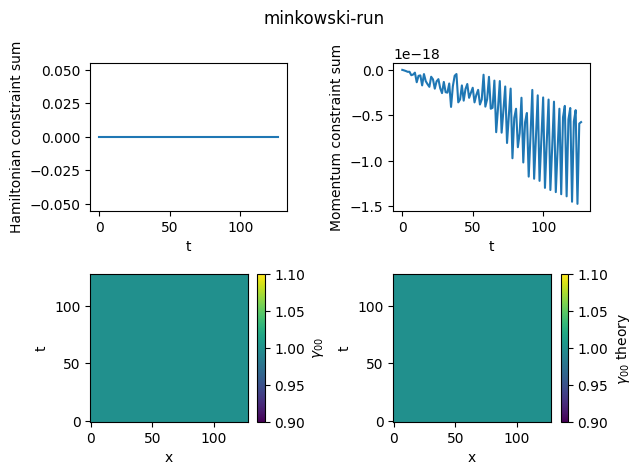

In [89]:
plot_output("/home/pamiro/repos/computational_physics_project/data/minkowski-run", minkowski_g00)

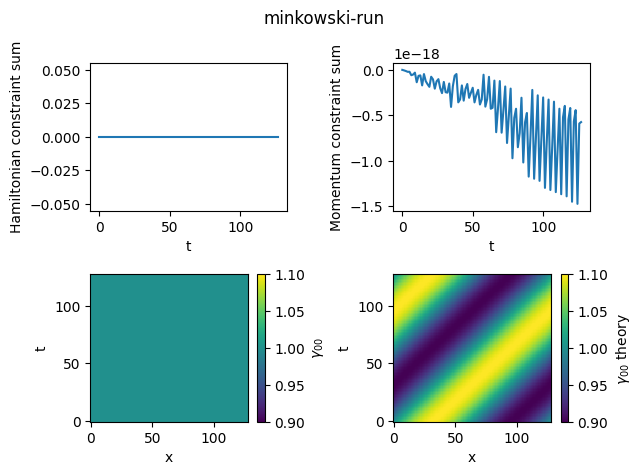

In [88]:
plot_output("/home/pamiro/repos/computational_physics_project/data/minkowski-run", gauge_wave_g00)